In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
# Load the data
df = pd.read_csv('.\Time_series\MLTempDataset.csv')
# Display the first few rows
print(df.head())


   Unnamed: 0  Datetime1  DAYTON_MW             Datetime
0           0          0     20.867  2022-01-04 00:00:00
1           1          1     21.000  2022-01-04 01:00:00
2           2          2     20.867  2022-01-04 02:00:00
3           3          3     20.650  2022-01-04 03:00:00
4           4          4     20.400  2022-01-04 04:00:00


<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\71518\AppData\Local\Temp\ipykernel_26468\1523765958.py:2: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv('.\Time_series\MLTempDataset.csv')


In [7]:
# Convert 'Datetime' to datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Drop unnecessary columns if any
df = df[['DAYTON_MW']]  # Assuming 'DAYTON_MW' is the target variable


In [8]:
df

,DAYTON_MW
Datetime,
2022-01-04 00:00:00,20.867
2022-01-04 01:00:00,21.000
2022-01-04 02:00:00,20.867
2022-01-04 03:00:00,20.650
2022-01-04 04:00:00,20.400
...,...
2022-10-08 23:00:00,27.350
2022-10-09 00:00:00,26.800
2022-10-09 01:00:00,26.450


In [9]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(df.values)

# Convert scaled data to a DataFrame
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)


In [10]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (e.g., using past 24 hours to predict the next hour)
sequence_length = 24

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X for RNN/LSTM [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f'Input shape: {X.shape}')
print(f'Target shape: {y.shape}')


Input shape: (6652, 24, 1)
Target shape: (6652, 1)


In [11]:
# Define the split ratio
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')


Training samples: 5321
Testing samples: 1331


In [12]:
# Initialize the RNN model
rnn_model = Sequential()

# Add SimpleRNN layer
rnn_model.add(SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, 1)))

# Add output layer
rnn_model.add(Dense(1))

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
rnn_model.summary()


C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the RNN model
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0849 - val_loss: 0.0084
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 12/100
133/133 ━━━━━━━━━━━━━━━━━━━━

In [14]:
# Initialize the LSTM model
lstm_model = Sequential()

# Add LSTM layer
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))

# Add output layer
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1392 - val_loss: 0.0185
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0198 - val_loss: 0.0121
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0141 - val_loss: 0.0088
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - val_loss: 0.0081
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0106 - val_loss: 0.0073


In [16]:
# RNN Predictions
rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [17]:
# Calculate Root Mean Squared Error for RNN
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions))
print(f'RNN RMSE: {rnn_rmse}')

# Calculate Root Mean Squared Error for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
print(f'LSTM RMSE: {lstm_rmse}')


RNN RMSE: 1.5710904566947115
LSTM RMSE: 2.45446518637163


In [19]:
from sklearn.metrics import r2_score

r2_rnn = r2_score(y_test_actual, rnn_predictions)
print(f'R^2 for RNN: {r2_rnn:.4f}')

R^2 for RNN: 0.8827


In [20]:
r2_rnn = r2_score(y_test_actual, lstm_predictions)
print(f'R^2 for lstm: {r2_rnn:.4f}')

R^2 for lstm: 0.7138


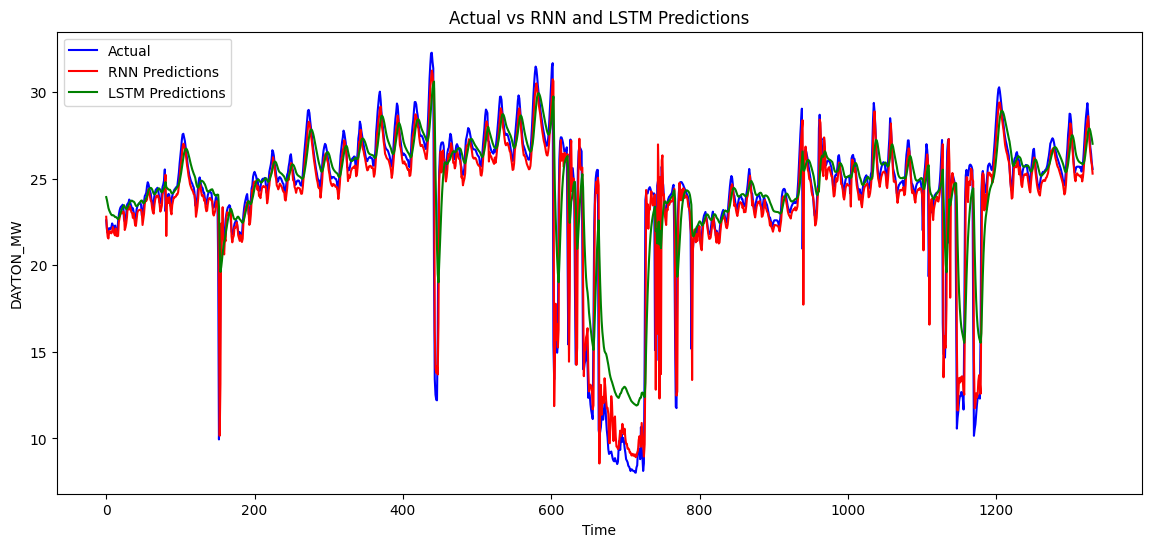

In [21]:
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(rnn_predictions, label='RNN Predictions', color='red')
plt.plot(lstm_predictions, label='LSTM Predictions', color='green')
plt.title('Actual vs RNN and LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('DAYTON_MW')
plt.legend()
plt.show()


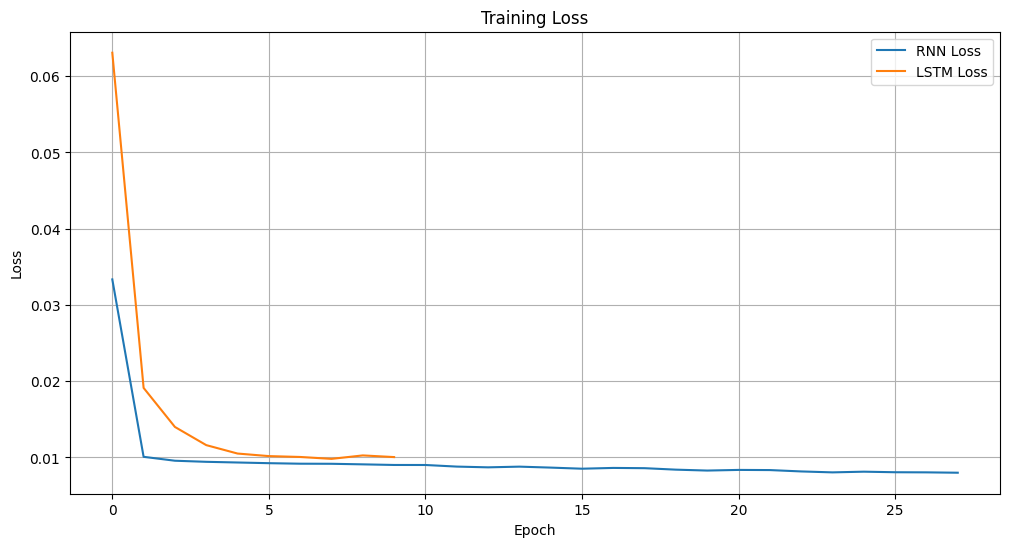

In [22]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='RNN Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Microsoft Stock

In [31]:
data = pd.read_csv('.\Time_series\Microsoft_Stock.csv')


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\71518\AppData\Local\Temp\ipykernel_26468\2579701543.py:1: SyntaxWarning: invalid escape sequence '\T'
  data = pd.read_csv('.\Time_series\Microsoft_Stock.csv')


In [32]:
data

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [33]:
# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])


In [35]:

# Create sequences
def create_sequences(data, sequence_length=3):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X, y = create_sequences(data['Close'].values, sequence_length)


In [36]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:

# Reshape for RNN/LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [38]:
# Build RNN model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)


Epoch 1/50


C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0874 - val_loss: 1.5413e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7845e-04 - val_loss: 1.2266e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7401e-04 - val_loss: 1.1562e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6465e-04 - val_loss: 1.1401e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8271e-04 - val_loss: 1.1013e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6933e-04 - val_loss: 1.0737e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4726e-04 - val_loss: 2.3943e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0978e-04 - val_loss: 1.3520e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6948e-04 - val_loss: 1.3062e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5457e-04 - val_loss: 1.0711e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7881e-04 - val_loss: 1.1300e-04
E

In [39]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1392 - val_loss: 0.0161
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 1.4196e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7365e-04 - val_loss: 1.2390e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6402e-04 - val_loss: 1.1722e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8532e-04 - val_loss: 1.1220e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6470e-04 - val_loss: 1.1352e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7241e-04 - val_loss: 1.2123e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7758e-04 - val_loss: 1.1795e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5176e-04 - val_loss: 1.3007e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1641e-04 - val_loss: 1.1113e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3612e-04 - val_loss: 1.3333e-0

In [40]:
# Predict and calculate R^2
y_pred_rnn = rnn_model.predict(X_val)
y_pred_lstm = lstm_model.predict(X_val)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [41]:
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

r2_rnn = r2_score(y_val_inv, y_pred_rnn_inv)
r2_lstm = r2_score(y_val_inv, y_pred_lstm_inv)

print(f'R^2 for RNN: {r2_rnn:.4f}')
print(f'R^2 for LSTM: {r2_lstm:.4f}')


R^2 for RNN: 0.9983
R^2 for LSTM: 0.9983


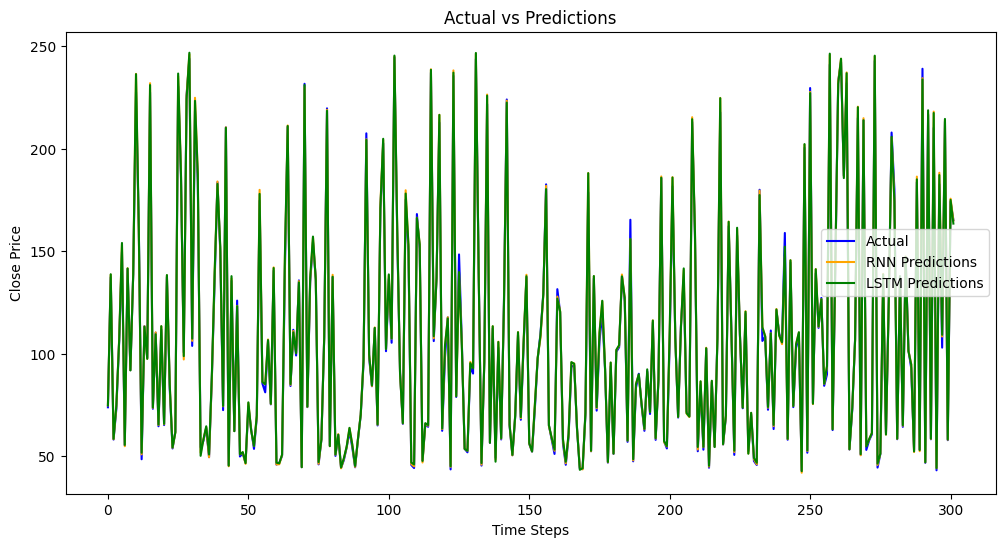

In [42]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual', color='blue')
plt.plot(y_pred_rnn_inv, label='RNN Predictions', color='orange')
plt.plot(y_pred_lstm_inv, label='LSTM Predictions', color='green')
plt.title('Actual vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()


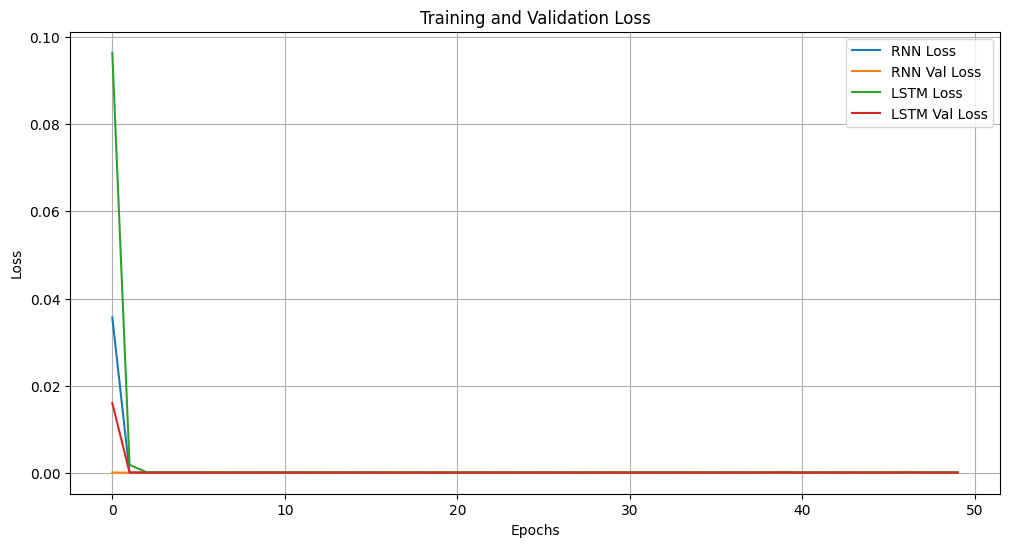

In [43]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='RNN Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [45]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, GaussianNoise
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build RNN model with regularization, noise, and dropout
rnn_model = Sequential([
    GaussianNoise(0.1),  # Add noise to inputs
    SimpleRNN(
        50, 
        activation='relu', 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_regularizer=l2(0.001)  # L2 regularization
    ),
    Dropout(0.5),  # Dropout for regularization
    Dense(1)  # Output layer
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse')

# Add callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Train the model
rnn_history = rnn_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=20, 
    batch_size=16, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0526 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 10/20
76/76 ━━━━━━━━━━

In [46]:
# Predict and calculate R^2
y_pred_rnn2 = rnn_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [47]:
y_pred_rnn_inv2 = scaler.inverse_transform(y_pred_rnn2)

r2_rnn2 = r2_score(y_val_inv, y_pred_rnn_inv2)

print(f'R^2 for RNN: {r2_rnn2:.4f}')

R^2 for RNN: 0.9929
